# Algoritmo GAN 
*Las GAN son un tipo de algoritmo de aprendizaje no supervisado.*
*Consisten en dos redes neuronales que compiten entre sí en un “juego de suma cero"*.
# Las dos partes: Generador y Discriminador:
-Generador: Intenta crear datos que parezcan reales (por ejemplo, imágenes, música o texto).

-Discriminador: Aprende a diferenciar entre datos reales y los generados por el generador.
# El proceso:
-El generador crea datos sintéticos.

-El discriminador evalúa si estos datos son auténticos o falsos.
# Ambas redes se mejoran mutuamente: 
el generador trata de engañar al discriminador, y este último se vuelve más hábil en detectar lo falso.
# Aplicaciones:
1. Generación de imágenes realistas.
Completar datos faltantes en conjuntos de datos.
2. Creación de música original.
3. Traducción automática de texto.

In [1]:
from __future__ import absolute_import , division , print_function , unicode_literals
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow as tf



## Importando los Datos

In [2]:
(tran_images , train_labels) , (_,_) = tf.keras.datasets.mnist.load_data()

*visualizacion de la cantidad de imagenes del set de datos*

In [3]:
tran_images.shape

(60000, 28, 28)

*mostrando las labels o etiquetas del set de datos*

In [4]:
train_labels.shape

(60000,)

# Reformando imagenes:
- Paso necesario para trabajar con ellas de manera adecuada 

In [5]:
# formato (28,28) y se le agrega una dimension mas
# tran_images.shape[0] -> referencia que se trabajan con las 60mil imagenes
train_images= tran_images.reshape(tran_images.shape[0],28,28,1).astype("float32")

In [6]:
train_images.shape

(60000, 28, 28, 1)

# Normalizacion de las Imagenes

In [7]:
train_images = (train_images - 127.5) / 127.5

## Eligiendo la cantidad de imagenes que se van a utilizar
*(en este caso particular todas las del set)*

In [8]:
#Cantida de imagenes
BUFFER_SIZE = 60000
#Cantidad de lotes de imagenes
BATCH_SIZE = 256

In [9]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Visualizacion del Set de Datos
- Como se esta trabajando con una sola dimension de color la imagen va a ser de color gris.

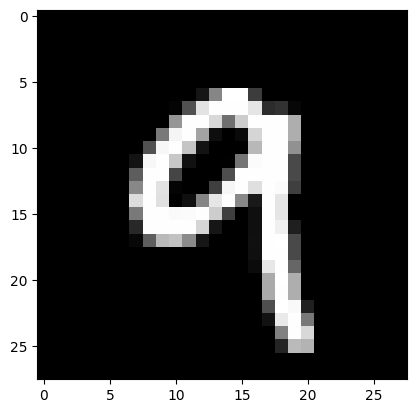

In [10]:
plt.imshow(train_images[110].reshape((28,28)), cmap="gray")

# Creando Generador 
- Toma una señal de ruido aleatorio y emite imagenes
- El generador trata de generar imagenes falsas que son similares a las reales
- El objetivo del generador es engañar al discriminador
- Las etiquetas estan marcadas de la siguiente manera:
1. la etiqueta = 1.0 -> indica imagenes reales
2. la etiqueta = 0.0 -> indica que son imagenes falsas
- El generador utiliza tf.keras.layers.Conv2DTranspose (upsampling) 

In [11]:
# Funcion Generador 
def make_generator_model():
    model = tf.keras.Sequential()
    # 1er capa 
    model.add(layers.Dense(7*7*256, use_bias=False , input_shape=(100,)))
    # capa de normalizacion
    model.add(layers.BatchNormalization())
    # capa relu para activacion
    model.add(layers.LeakyReLU())
    # capa de reformacion de la imagen
    model.add(layers.Reshape((7, 7, 256)))
    # Debido que se utiliza el "mismo" relleno y los saltos (strides) = 1:
    # capas de convolucion: con 128 filtros de 5 x 5
    model.add(layers.Conv2DTranspose(128,(5,5) , 
                                     strides=(1,1),
                                     padding="same",
                                     use_bias=False 
                                     ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    # capas de convolucion: con 64 filtros de 5 x 5, con saltos de 2 en 2 
    model.add(layers.Conv2DTranspose(64,(5,5) , 
                                     strides=(2,2),
                                     padding="same",
                                     use_bias=False 
                                     ))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    # capas de convolucion: con 1 filtro de 5 x 5, con saltos de 2 en 2
    # neurona de salida 
    model.add(layers.Conv2DTranspose(1,(5,5) , 
                                     strides=(2,2),
                                     padding="same",
                                     use_bias=False,
                                     activation="tanh" 
                                     ))
    model.summary()
    return model

In [12]:
generator = make_generator_model()

d:\CURSOS\NOTEBOOKS\Redes Generativas Adversariales\RedesGenerativasAdversariales\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 28, 28, 1)      │         1,600 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

# Creando Ruido Aleatorio en las imagenes

In [13]:
noise = tf.random.normal([1,100])
generated_image=generator(noise, training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

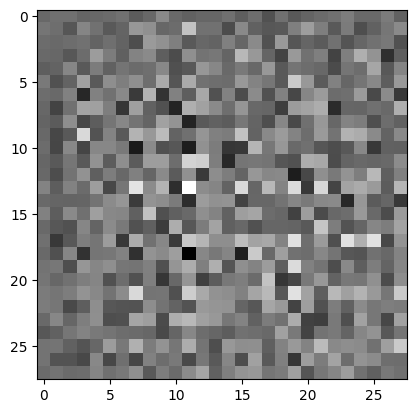

In [14]:
imagen_falsa= plt.imshow(generated_image[0,:,:,0] , cmap="gray")
imagen_falsa

# Creando el Discriminador de las Imagenes
- Esta entrenado para hacer lo siguiente:
1. salida 0 (probabilidad = 0%) cuando la imagen de entrada es falsa
2. salida 1 (probabilidad = 100%) cuando la imagen de entrada es real

In [15]:
def make_discriminator_model():
    # Se crea un modelo secuencial vacío
    # Las capas se agregarán secuencialmente
    model = tf.keras.Sequential()
    # La primera tiene 64 filtros, un tamaño de kernel de (5, 5), 
    # un stride de (2, 2) y utiliza la función de activación LeakyReLU.
    model.add(layers.Conv2D(64, (5, 5), 
                            strides=(2, 2), 
                            padding='same', 
                            input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    # Se agrega una capa de dropout con una tasa del 30%,
    # después de cada capa convolucional para evitar el sobreajuste.
    model.add(layers.Dropout(0.3))
    #La segunda tiene 128 filtros, un tamaño de kernel de (5, 5), 
    # un stride de (2, 2) y también utiliza LeakyReLU.
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    # Capa dropout para evitar sobreajuste
    model.add(layers.Dropout(0.3))
    # Se agrega una capa Flatten para aplanar la salida de las capas convolucionales.
    model.add(layers.Flatten())
    # Se agrega una capa densa con una sola neurona 
    # (para la clasificación binaria) sin función de activación explícita.
    model.add(layers.Dense(1))
    # Se muestra un resumen del modelo.
    model.summary()

    return model

In [16]:
discriminator = make_discriminator_model()


d:\CURSOS\NOTEBOOKS\Redes Generativas Adversariales\RedesGenerativasAdversariales\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

# Haciendo predicciones con el modelo

In [17]:
decision = discriminator(generated_image)

In [18]:
print(f"Para la imagen{imagen_falsa} la decision es {decision}")

Para la imagenAxesImage(shape=(28, 28)) la decision es [[-0.0002385]]


# Funcion de Perdida para el Generador
- Calcula la perdida que es la diferencia entre las decisiones y la realidad

In [19]:
# entropia cruzada
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

- La perdida del discriminador indica lo bien que el discriminador es capaz de distinguir imagenes reales de imagenes falsas
- comprara las predicciones del discriminador sobre las imagenes reales

In [20]:
def discriminator_loss(real_output , fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output )
    total_loss = real_loss + fake_loss
    return total_loss

# Funcion de perdida del Generador

- Esta funcion de perdida del generador cuantifica lo bien que fue capaz de engañar al discriminador las imagenes hechas por el generador

In [21]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output) , fake_output)

# Generando Optimizador Adam 
- El optimizador Adam se utiliza comúnmente en GANs debido a su eficacia en la optimización de redes neuronales. 
- El valor 1e-4 representa la tasa de aprendizaje (learning rate) utilizada por el optimizador.

In [22]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Creando Checkpoints para la Red
- Este fragmento de código configura la gestión de checkpoints para un modelo GAN (Generative Adversarial Network).
- Los checkpoints son importantes para asegurar que puedas guardar el progreso del entrenamiento y recuperarlo en caso de interrupciones o para evaluar el modelo después del entrenamiento.

In [23]:
#Directorio
checkpoint_dir = './training_checkpoints'
#Creacion de la Ruta
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# Creacion del objeto de guardado
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# Entrenamiento del Modelo
- configuracion de parámetros importantes para el entrenamiento y la generación de ejemplos en una red GAN

In [24]:
#Se establece el número total de épocas (iteraciones completas a través del conjunto de datos) 
#EPOCHS = 100
EPOCHS = 30 # -> 
# La dimensión del ruido es la longitud del vector de entrada aleatorio que se utiliza como entrada para el generado
noise_dim = 100
# Definicion de los ejemplos generados
num_examples_to_generate = 16
# se crea una matriz de numeros aleatorios extraidos de una distribucion normal(Gaussiana)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

- Esta función representa un paso de entrenamiento en una red GAN. El generador intenta generar imágenes más realistas, mientras que el discriminador aprende a distinguir entre imágenes reales y generadas.

In [25]:
@tf.function
def train_step(images):
    #se crea un tensor de ruido aleatorio utilizando la distribución normal (Gaussiana)
    noise = tf.random.normal([BATCH_SIZE, noise_dim]) # BATCH_SIZE -> tamaño lote , noise_dim es la dimensión del espacio de ruido.

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      #Se llama al generador con la entrada de ruido aleatorio (noise). 
      # Esto genera imágenes sintéticas (falsas) 
      # que se utilizarán para engañar al discriminador.
      generated_images = generator(noise, training=True) 
      #El discriminador evalúa las imágenes reales (images)+
      # y calcula la salida (probabilidad) de que sean reales
      real_output = discriminator(images, training=True) 
      #: El discriminador también evalúa las imágenes generadas (generated_images) 
      # y calcula la salida (probabilidad) de que sean falsas.
      fake_output = discriminator(generated_images, training=True)
      
      # Se calcula la pérdida del generador utilizando la salida 
      # del discriminador para las imágenes generadas
      gen_loss = generator_loss(fake_output) 
      disc_loss = discriminator_loss(real_output, fake_output)
    # Aplicando optimizacion al optimizador y discriminador 
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables) 
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    # Aplicando gradientes al optimizador tanto del generador como el discriminador
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables)) 
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [29]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Producir imágenes para el GIF sobre la marcha
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Guardar el modelo cada 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Tiempo de epoca {} es {} segundos'.format(epoch + 1, time.time()-start))

  # Generar luego del epoch final
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)


In [32]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('imagen_de_epoca_{:04d}.png'.format(epoch))
  plt.show()

In [60]:
train(train_dataset, EPOCHS)

TypeError: train() got an unexpected keyword argument 'EPOCHS'

In [ ]:
#se restaura el modelo desde el último punto de control (checkpoint) 
# guardado en el directorio especificado (checkpoint_dir)
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [59]:
# Mostrar una sola imagen usando el número de Epoch
# La función abre y devuelve una imagen con nombre de archivo formateado según 
# el número de época proporcionado. Ejemplo, si epoch_no es 100,
# buscará y mostrará la imagen llamada “image_at_epoch_0100.png”.
def display_image(epoch_no):
  return PIL.Image.open('imagen_de_epoca_{:4d}.png'.format(epoch_no))

display_image(EPOCHS)

FileNotFoundError: [Errno 2] No such file or directory: 'D:\\CURSOS\\NOTEBOOKS\\Redes Generativas Adversariales\\imagen_de_epoca_ 100.png'

In [63]:
# Mostrar la imagen correspondiente a la última época registrada
def display_last_epoch_image(last_epoch):
    filename = 'imagen_de_epoca_{:01d}.png'.format(last_epoch)
    
    if os.path.exists(filename):
        return PIL.Image.open(filename)
    else:
        print(f"El archivo '{filename}' no se encontró en la ubicación especificada.")
        
    return PIL.Image.open(filename)
# Supongamos que EPOCHS contiene el número de la última época registrado
# (asegúrate de asignar el valor correcto antes de llamar a la función)
last_epoch_number = EPOCHS
last_epoch_image = display_last_epoch_image(last_epoch_number)
last_epoch_image.show()  # Esto mostrará la imagen en tu visor de imágenes predeterminado
if last_epoch_image:
    last_epoch_image.show()  # Esto mostrará la imagen en tu visor de imágenes predeterminado

El archivo 'imagen_de_epoca_0100.png' no se encontró en la ubicación especificada.


FileNotFoundError: [Errno 2] No such file or directory: 'D:\\CURSOS\\NOTEBOOKS\\Redes Generativas Adversariales\\imagen_de_epoca_0100.png'